# Estimate the age of an abalone using a neural network

This report highlights a data-driven approach to estimating the age of the abalones when they go to market. Traditionally, determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. We will also explore whether other physical characteristics can help estimate age.

The report focuses on three key questions:
1. How does weight change with age for each of the three sex categories?
2. How can we estimate an abalone's age using its physical characteristics?
3. Which variables are better predictors of age for abalones?

## 📖 Executive Summary

- Overall, there is a positive heteroscedastic relationship between age and weight. `I` group samples generally have smaller weight values. `M` and `F` have similar ranges for weight, with F being slightly higher.
- We built a simple neural network that is trained on the abalones' physical characteristics to estimate their age.
- The number of rings is the best predictor of age for abalones. This is followed by a combination of it's length and sex, and length is highly correlated to its diameter, height, and weight.

In [1]:
%%capture
%pip install watermark
%pip install shap
%pip install shutup

import shutup; shutup.please()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from watermark import watermark
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import sklearn.metrics as metrics
import shap

# Set style
plt.style.use('fivethirtyeight')

2022-10-23 04:34:57.922615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-23 04:34:57.922647: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Creates function to generate a data quality report
def dqr(df):
    """
    Generate a data quality report
    
    ARGS:
    df (dataframe): Pandas dataframe
    
    OUTPUT:
    dq_report: First few rows of dataframe, descriptive statistics, and other info such as missing data and unique values etc.
    """
    display(df.head())
    display(df.describe().round(1).T)
    
    # data type
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
  
    # missing data
    missing_data = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])

    # unique values
    unique_values = pd.DataFrame(columns=['Unique Values'])
    for row in list(df.columns.values):
        unique_values.loc[row] = [df[row].nunique()]
    
    # number of records
    count_values = pd.DataFrame(columns=['Records'])
    for row in list(df.columns.values):
        count_values.loc[row] = [df[row].count()]
        
    # join columns 
    dq_report = data_types.join(count_values).join(missing_data).join(unique_values)
  
    # percentage missing
    dq_report['Missing %'] = (dq_report['Missing Values'] / len(df) *100).round(2)
  
    # change order of columns
    dq_report = dq_report[['Data Type', 'Records', 'Unique Values', 'Missing Values', 'Missing %']]

    return dq_report

# Plot the validation and training data separately
def plot_loss_curves(history, metric):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history[metric]
    val_accuracy = history.history[f'val_{metric}']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot metric
    plt.figure()
    plt.plot(epochs, accuracy, label=f'training_{metric}')
    plt.plot(epochs, val_accuracy, label=f'val_{metric}')
    plt.title(f'{metric}')
    plt.xlabel('Epochs')
    plt.legend()

def plot_predictions(train_data, 
                     train_labels,
                     test_data, 
                     test_labels, 
                     predictions):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", label="Training data")
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", label="Testing data")
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", label="Predictions")
    # Show the legend
    plt.legend()
    
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## 💾 The data

The dataset is from [UCI Machine Learning Respiratory](https://archive.ics.uci.edu/ml/datasets/abalone). 

### Abalone characteristics:
- "sex" - M, F, and I (infant).
- "length" - longest shell measurement.
- "diameter" - perpendicular to the length.
- "height" - measured with meat in the shell.
- "whole_wt" - whole abalone weight.
- "shucked_wt" - the weight of abalone meat.
- "viscera_wt" - gut-weight.
- "shell_wt" - the weight of the dried shell.
- "rings" - number of rings in a shell cross-section.
- "age" - the age of the abalone: the number of rings + 1.5.

***Acknowledgments**: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn, and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288).*

## Exploratory Data Analysis

In [3]:
abalone = pd.read_csv('./data/abalone.csv')
dqr(abalone)

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


,count,mean,std,min,25%,50%,75%,max
length,4177.0,0.5,0.1,0.1,0.4,0.5,0.6,0.8
diameter,4177.0,0.4,0.1,0.1,0.4,0.4,0.5,0.6
height,4177.0,0.1,0.0,0.0,0.1,0.1,0.2,1.1
whole_wt,4177.0,0.8,0.5,0.0,0.4,0.8,1.2,2.8
shucked_wt,4177.0,0.4,0.2,0.0,0.2,0.3,0.5,1.5
viscera_wt,4177.0,0.2,0.1,0.0,0.1,0.2,0.3,0.8
shell_wt,4177.0,0.2,0.1,0.0,0.1,0.2,0.3,1.0
rings,4177.0,9.9,3.2,1.0,8.0,9.0,11.0,29.0
age,4177.0,11.4,3.2,2.5,9.5,10.5,12.5,30.5


,Data Type,Records,Unique Values,Missing Values,Missing %
sex,object,4177,3,0,0.0
length,float64,4177,134,0,0.0
diameter,float64,4177,111,0,0.0
height,float64,4177,51,0,0.0
whole_wt,float64,4177,2429,0,0.0
shucked_wt,float64,4177,1515,0,0.0
viscera_wt,float64,4177,880,0,0.0
shell_wt,float64,4177,926,0,0.0
rings,int64,4177,28,0,0.0
age,float64,4177,28,0,0.0


The dataset contains 4177 records, 9 variables and no missing values. The descriptive statistics summary for numerical variables gives us the rough idea what the data looks like. The ranges vary across dataframe, with a maximum of 29.0 for `rings` and 2.8 for `whole_wt`. The minimum of `height`, 0.0 ,is likely a reporting error, as seen below since the rows with a height of 0.0 have positive `length` and weights. Since this is only 2 rows, we will drop them from the dataset.

Skewness that is close to 0 suggests they are similar to a normal distribution curve.
`height` has the highest skewness of 3.13. Hints that there are outliers in height, which we can remove using the IQR algorithm before modeling.

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
objects = ['object']

# Minimum of each numerical columns
for i in abalone.select_dtypes(include=numerics).columns:
    print(i, abalone.select_dtypes(include=numerics)[f'{i}'].min())

# Rows with height of 0.0
display(abalone[abalone.height == 0.0])

length 0.075
diameter 0.055
height 0.0
whole_wt 0.002
shucked_wt 0.001
viscera_wt 0.0005
shell_wt 0.0015
rings 1
age 2.5


,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8,9.5
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6,7.5


In [5]:
# Remove rows with 0 height from dataset
abalone = abalone[abalone.height != 0]

In [6]:
abalone.skew().sort_values(ascending = False)

height        3.166364
rings         1.113754
age           1.113754
shucked_wt    0.718735
shell_wt      0.621081
viscera_wt    0.591455
whole_wt      0.530549
diameter     -0.610182
length       -0.640993
dtype: float64

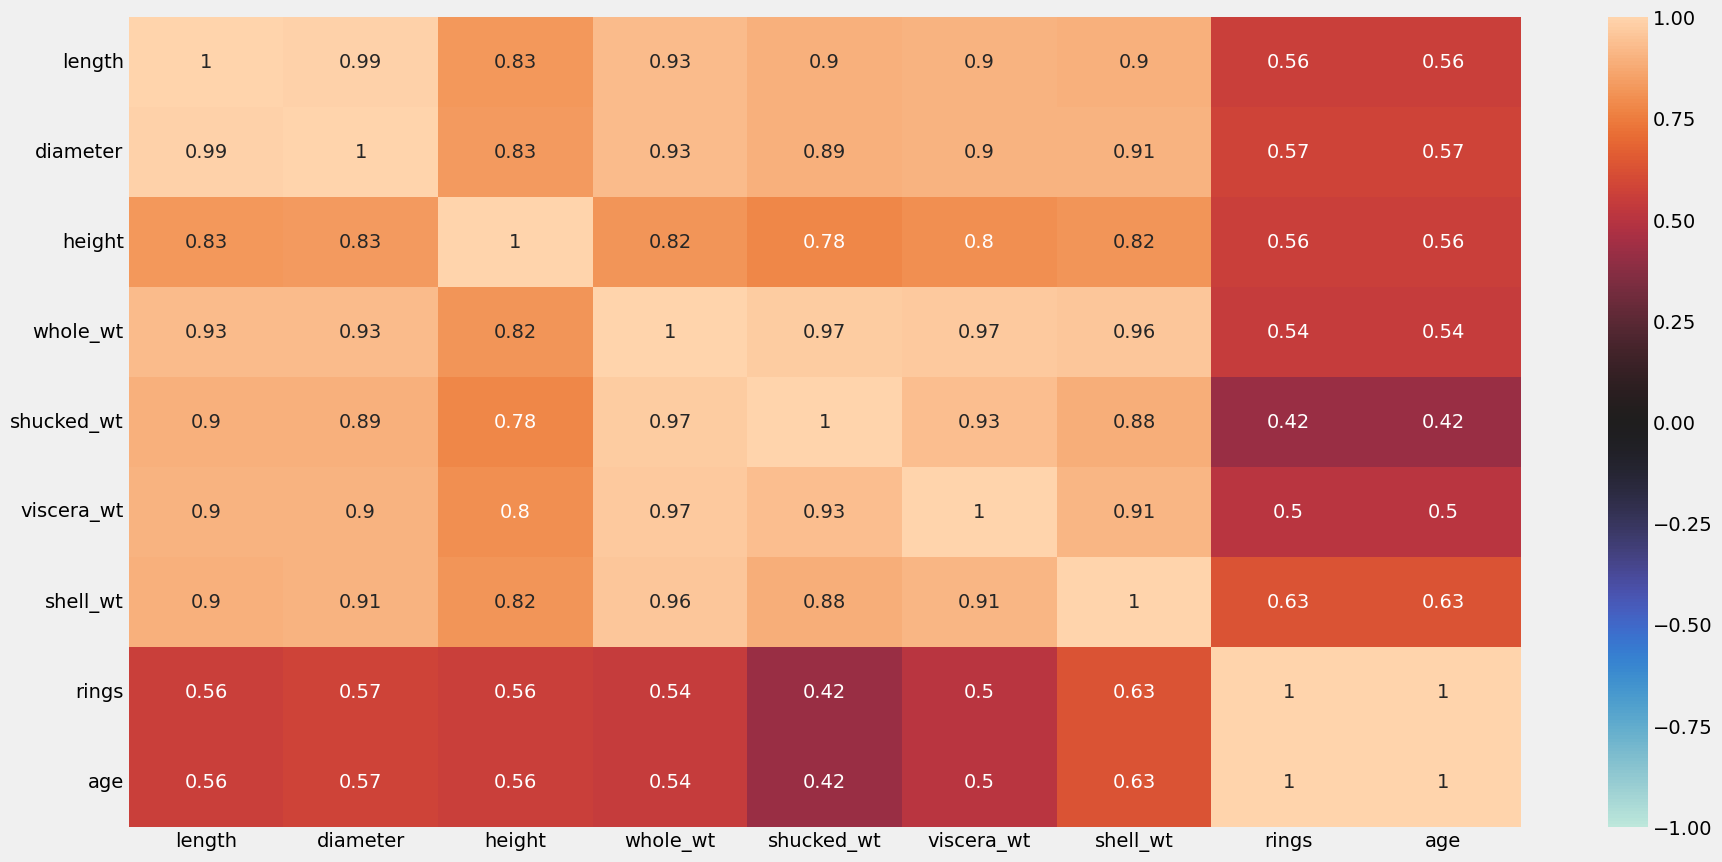

In [7]:
corr = abalone.corr()
plt.figure(figsize = (20,10))
ax = sns.heatmap(corr, vmin = -1, center = 0, annot = True)

There are no negative correlations. There is a high correlations between `length`, `diameter`, `height`, `whole-wt`, `shucked_wt`, `viscera_wt`, and `shell_wt`. Let's remove the highly correlated variables.

In [8]:
# Remove highly correlated columns
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
columns_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
columns_to_drop.remove('age')
print("Columns dropped:", columns_to_drop)
abalone = abalone.drop(columns_to_drop, axis=1)

Columns dropped: ['diameter', 'shucked_wt', 'viscera_wt', 'shell_wt']


## Weight-by-age per sex analysis

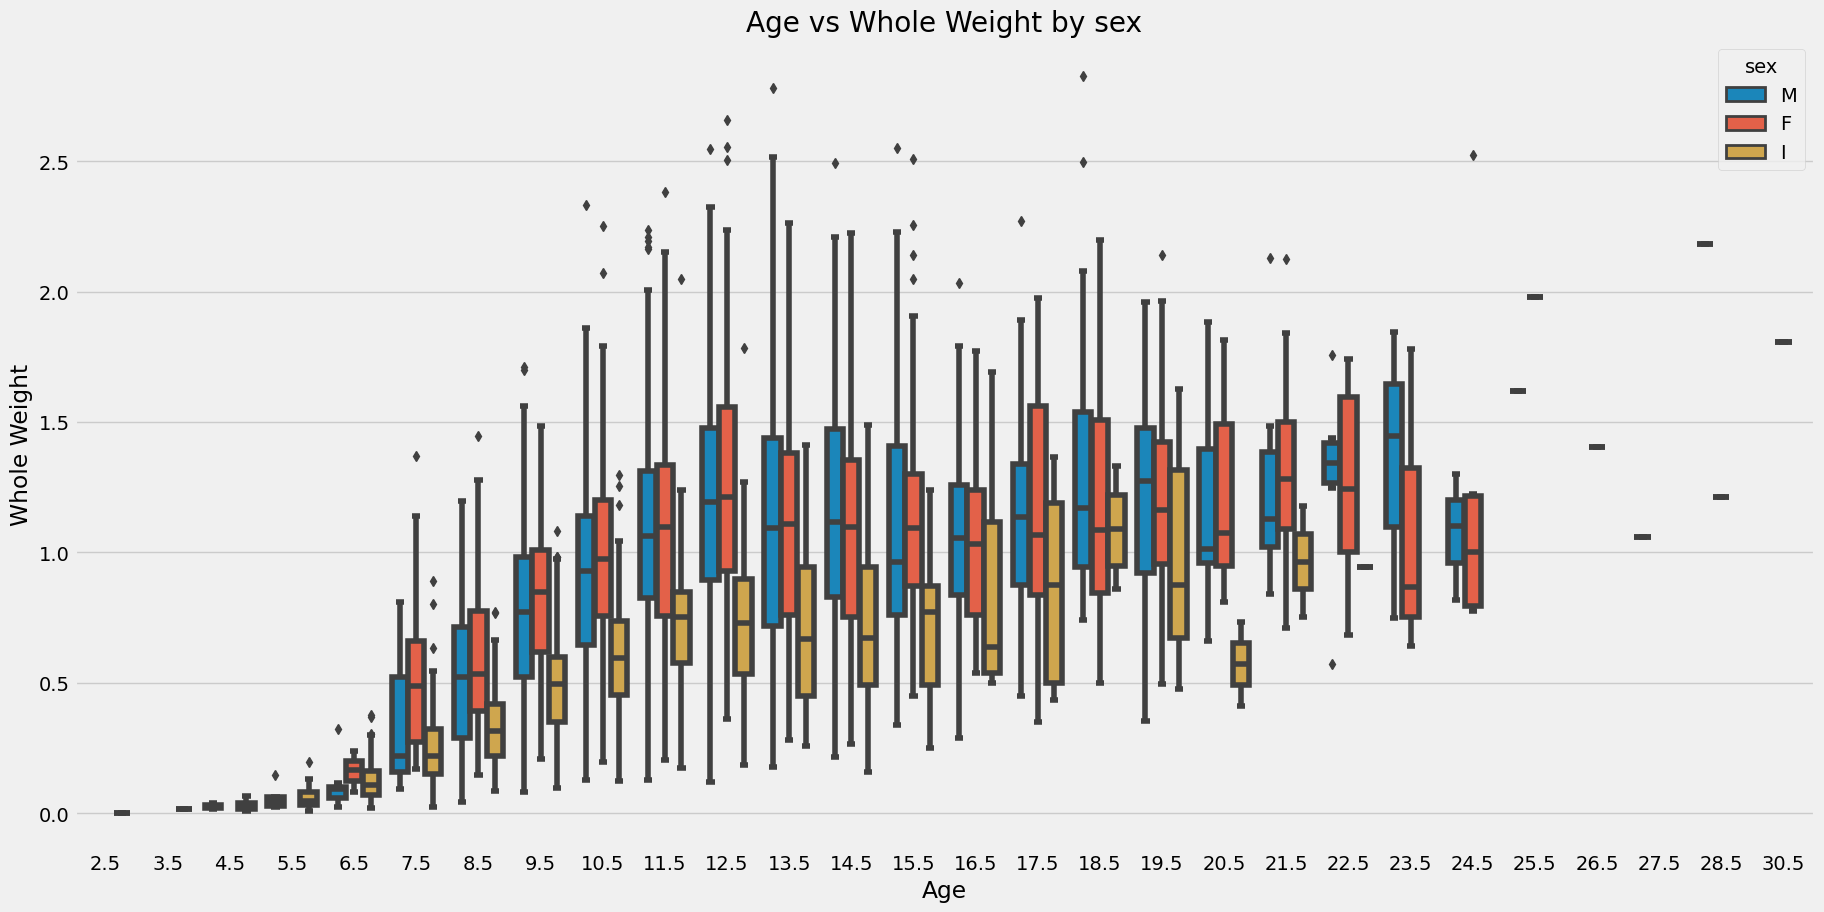

In [9]:
plt.figure(figsize = (20,10))
sns.boxplot(abalone['age'], abalone["whole_wt"], hue = abalone['sex'])
plt.title(f'Age vs Whole Weight by sex')
plt.ylabel(f'Whole Weight')
plt.xlabel('Age')
plt.show()

The charts above show how abalone whole weight changes at different ages, split by three sex categories (male, female, infant). Overall, there is a positive heteroscedastic relationship between age and weight. The growth rate for weight starts of slow till an age 5.5. It picks up and starts to peak and plateau around age 12.5. `I` group samples generally have smaller weight values. `M` and `F` have similar ranges for weight, with 'F' being slightly higher. The weights have less variability between 0 and 5.5, and then increase in age. There are also less records of abalone at ages past 24.5.

## Data Preprocessing

- The data is split into training (80%), validation (10%), test (10%) datasets.
- The numerical features are normalized and the categorical features are one-hot encoded.

In [10]:
target_col = 'age'

# Create X & y
X = abalone.drop(target_col, axis=1)
y = abalone[target_col]

num_cols = X.select_dtypes(include=numerics).columns.tolist()
cat_cols = X.select_dtypes(include=objects).columns.tolist()

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), num_cols), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), cat_cols)
)

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build our val and test sets (use random state to ensure same split as before)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Get Feature Names
feature_names = list(ct.get_feature_names_out())

# Transform training, validation and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_val_normal = ct.transform(X_val)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, X_val_normal.shape, X_test_normal.shape

((3340, 7), (417, 7), (418, 7))

## Build model

In [11]:
# Set random seed
tf.random.set_seed(42)

model = Sequential([
    Dense(10),
    Dense(1)
])

# Compile the model
model.compile(loss='mae',
                optimizer=tf.keras.optimizers.SGD(lr=0.01),
                metrics=['mae'])

early_stopping = EarlyStopping(monitor='loss', patience=3)
# Fit the model
history = model.fit(X_train_normal, y_train, 
                    epochs=70,
                    steps_per_epoch=len(X_train_normal),
                    validation_data=(X_val_normal, y_val),
                    validation_steps=len(X_val_normal), 
                    callbacks=early_stopping,
                    verbose=0
                   )
y_pred = model.predict(X_test_normal)

2022-10-23 04:35:01.832071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-23 04:35:01.832104: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-23 04:35:01.832125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1c2a3c32-cd77-4541-925e-7582e57c1fbe): /proc/driver/nvidia/version does not exist
2022-10-23 04:35:01.832475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 0s 859us/step


 1/14 [=>............................] - ETA: 1s

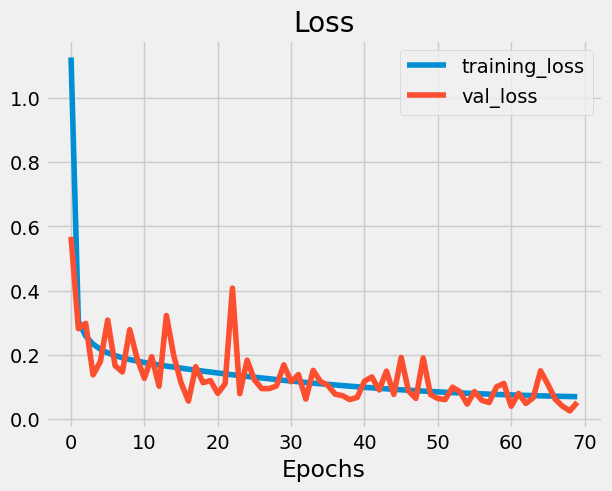

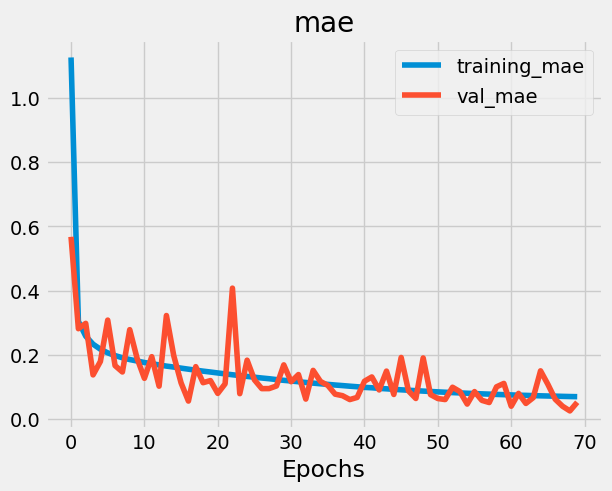

In [12]:
plot_loss_curves(history, 'mae')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [14]:
regression_results(y_test, y_pred)

explained_variance:  1.0
mean_squared_log_error:  0.0
r2:  0.9997
MAE:  0.0558
MSE:  0.0037
RMSE:  0.0608


After looking at the regression metrics, the model predictions looks pretty good. 

## Feature Importance

In [16]:
shap.initjs()
# Compute SHAP values
explainer = shap.DeepExplainer(model, X_train_normal)
shap_values = explainer.shap_values(X_test_normal)

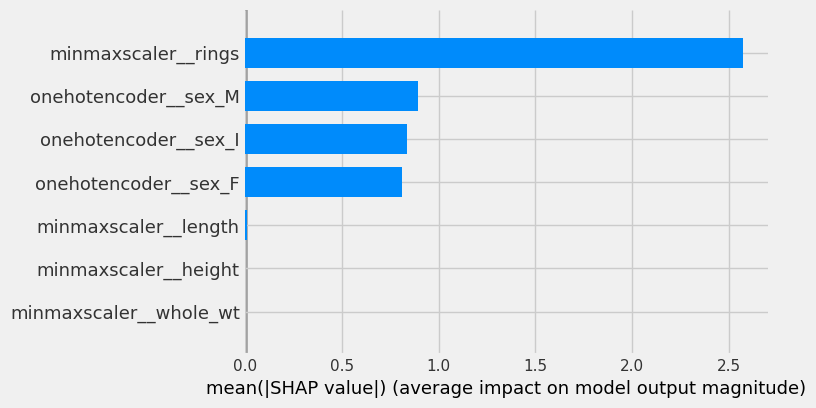

In [17]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = feature_names)

As expected, the number of rings is the most important feature and has the greatest impact on predicting age.

14/14 [==============================] - 0s 1ms/step


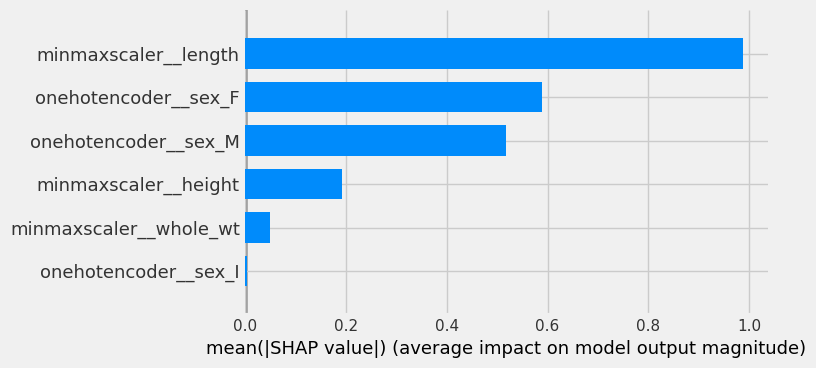

In [18]:
# Create X & y
X = abalone.drop(target_col, axis=1).drop('rings', axis=1)
y = abalone[target_col]

num_cols = X.select_dtypes(include=numerics).columns.tolist()
cat_cols = X.select_dtypes(include=objects).columns.tolist()

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), num_cols), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), cat_cols)
)

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build our val and test sets (use random state to ensure same split as before)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Get Feature Names
feature_names = list(ct.get_feature_names_out())

# Transform training, validation and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_val_normal = ct.transform(X_val)
X_test_normal = ct.transform(X_test)

# Set random seed
tf.random.set_seed(42)

model = Sequential([
    Dense(10),
    Dense(1)
])

# Compile the model
model.compile(loss='mae',
                optimizer=tf.keras.optimizers.SGD(lr=0.01),
                metrics=['mae'])

early_stopping = EarlyStopping(monitor='loss', patience=3)
# Fit the model
history = model.fit(X_train_normal, y_train, 
                    epochs=70,
                    steps_per_epoch=len(X_train_normal),
                    validation_data=(X_val_normal, y_val),
                    validation_steps=len(X_val_normal), 
                    callbacks=early_stopping,
                    verbose=0
                   )
y_pred = model.predict(X_test_normal)

explainer = shap.DeepExplainer(model, X_train_normal)
shap_values = explainer.shap_values(X_test_normal)

shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = feature_names)

Let's consider removing the data containing number of rings. Now the most important feature is length. This is understandable since we know from EDA that `length` is also highly correlated to `diameter`, `height`, `whole-wt`, `shucked_wt`, `viscera_wt`, and `shell_wt` and that there is a positive relationship between these values and age. `sex` has a larger impact here, likely because groups with sex `I` have lower weights across all ages compared to `M` and `F`.

## Appendix

In [19]:
%load_ext watermark
%watermark --iversions

shutup    : 0.2.0
seaborn   : 0.11.2
sklearn   : 1.1.2
shap      : 0.41.0
tensorflow: 2.9.1
numpy     : 1.23.4
pandas    : 1.5.1
matplotlib: 3.5.3

